In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
from time import sleep

import twitter, re, datetime, pandas as pd
import sys
import re
import time
import tweepy
from pprint import pprint 

import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle 
# Custom Imports and scripts
import os, sys
cwd = os.getcwd()
sys.path.append(cwd+'/scripts/')

from importlib import import_module
import_module("my_bigq")
import_module("run_weather")
from my_bigq import bigquery_handler 
import run_weather as rw
import run_twitter as rt

In [25]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

In [4]:
# Load Data
q_base_weather = """
SELECT * 
FROM metridaticsmain.webscrapes.weather_data
"""
q_base_twitter = """
SELECT * 
FROM metridaticsmain.webscrapes.twitter_data_raw
"""

# https://googleapis.dev/python/bigquery/latest/usage/pandas.html
df_weather = bigquery_handler(q_base = q_base_weather).run_query(how='selects')
df_twitter_r = bigquery_handler(q_base = q_base_twitter).run_query(how='selects')

In [5]:
# De-dupe and downselect cities
df_weather = df_weather.drop_duplicates(['weather_main', 'weather_description', 'temp_K', 'temp_F',
       'pressure', 'humidity', 'temp_min', 'temp_max', 'sea_level',
       'grnd_level', 'visibility', 'wind_speed', 'wind_deg', 'rain_type',
       'rain_list', 'clouds', 'city_name']).reset_index().drop('index', axis=1)

df_weather=df_weather[df_weather.city_name.apply(lambda x: x in ['Austin', 'Seattle'])].reset_index().drop('index', axis=1)

df_twitter_r = df_twitter_r.drop_duplicates(['tweet_time', 'tweet_text', 'tweet_place']).reset_index().drop('index', axis=1)
df_twitter_r = df_twitter_r[df_twitter_r.tweet_place.isin(['Austin, TX', 'Seattle, WA'])].reset_index().drop('index', axis=1)

In [6]:
# standardize
def city_mapper(x):
    if x == 'Austin, TX':
        return 'Austin'
    if x == 'Seattle, WA':
        return 'Seattle'
    return 'other'

df_weather['is_rain'] = df_weather.weather_main == 'Rain'
df_weather['hour_trunc'] = df_weather.timestamp.dt.floor('h')

df_twitter_r['hour_trunc'] = df_twitter_r.tweet_time.dt.floor('h')
df_twitter_r['city_name'] = df_twitter_r['tweet_place'].apply(lambda x: city_mapper(x))

print('Tweets Found: ', df_twitter_r.shape[0], '. Weather Found: ', df_weather.shape[0])

Tweets Found:  17588 . Weather Found:  341


/home/conor/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


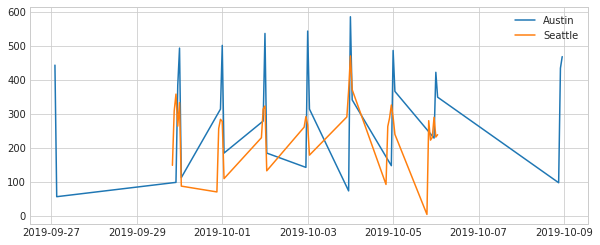

In [7]:
fig, ax = plt.subplots()
fig.set_figwidth(10)

ax.plot(df_twitter_r[df_twitter_r.city_name=='Austin'].groupby(['hour_trunc']).count()['tweet_time'], label='Austin')
ax.plot(df_twitter_r[df_twitter_r.city_name=='Seattle'].groupby(['hour_trunc']).count()['tweet_time'], label='Seattle')

ax.legend()

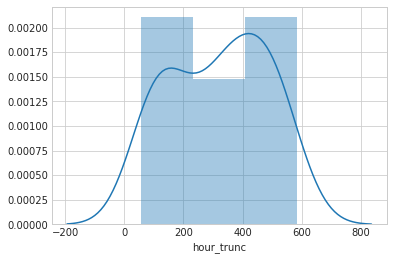

In [8]:
sns.distplot(df_twitter_r[df_twitter_r.city_name=='Austin']['hour_trunc'].value_counts())

# Refit model here
Plan:
* Cvec twitter
* Get rolling count - 1 hour, 24 hour
* Join to weather for target class
* Predict!

In [9]:
# vectorize

In [45]:
simple_cvec = CountVectorizer()
twitter_vectorized = simple_cvec.fit_transform(df_twitter_r.tweet_text)
twitter_vectorized = pd.DataFrame(twitter_vectorized.toarray(), columns=simple_cvec.get_feature_names())

good_feats = twitter_vectorized.sum()>10
good_feats = list(good_feats[good_feats].index)
twitter_vectorized = twitter_vectorized.loc[:, good_feats]

twitter_vectorized['tweet_time'] = df_twitter_r['tweet_time']
twitter_vectorized['is_Austin'] = (df_twitter_r['city_name'] == 'Austin')
twitter_vectorized.set_index('tweet_time', inplace=True)

In [97]:
# pickle.dump(simple_cvec, open("info/cvec_simple.sav", 'wb'))
# twitter_vectorized.to_csv('./info/data/twitter_vectorized.csv', index=True)

## Reopen here

In [12]:
simple_cvec = pickle.load(open('info/cvec_simple.sav', 'rb'))

twitter_vectorized = pd.read_csv('./info/data/twitter_vectorized.csv')
twitter_vectorized = twitter_vectorized.set_index(pd.to_datetime(twitter_vectorized.tweet_time)).drop('tweet_time', axis=1)

In [14]:
tv_austin = twitter_vectorized[twitter_vectorized.is_Austin].drop('is_Austin', axis=1)

# simple: From 25 until 2 hours ago
tv_austin_1s = tv_austin.resample("1s").sum().fillna(0)
tv_austin_25h = tv_austin_1s.rolling(window=25*60*60, min_periods=1).sum()
tv_austin_2h = tv_austin_1s.rolling(window=2*60*60, min_periods=1).sum()

tv_austin_diff = tv_austin_25h - tv_austin_2h

In [15]:
tv_austin_diff.head()


,10,100,11,15,1st,20,2019,2020,30,50,...,yes,yesterday,yet,yo,you,your,youre,yourself,youtube,zero
tweet_time,,,,,,,,,,,,,,,,,,,,,
2019-09-27 02:09:04+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-27 02:09:05+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-27 02:09:06+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-27 02:09:07+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-27 02:09:08+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
tv_austin_diff['hour_trunc'] = pd.Series(tv_austin_diff.index, index=tv_austin_diff.index).dt.floor('h')

In [17]:
df_weather

,timestamp,weather_main,weather_description,temp_K,temp_F,pressure,humidity,temp_min,temp_max,sea_level,grnd_level,visibility,wind_speed,wind_deg,rain_type,rain_list,clouds,city_name,is_rain,hour_trunc
0,2019-10-08 23:56:39.993250+00:00,Clear,clear sky,300.85,81.86,1016,31,298.71,302.15,None,None,16093,2.1,100,None,None,1,Austin,False,2019-10-08 23:00:00+00:00
1,2019-10-08 23:56:42.903176+00:00,Rain,light rain,281.63,47.264,1015,76,278.71,284.26,None,None,16093,1.5,90,None,None,40,Seattle,True,2019-10-08 23:00:00+00:00
2,2019-10-02 13:31:09.038475+00:00,Fog,fog,297.07,75.056,1017,94,295.93,298.15,None,None,None,1.5,100,None,None,90,Austin,False,2019-10-02 13:00:00+00:00
3,2019-10-05 03:50:32.275155+00:00,Haze,haze,299.35,79.16,1017,57,297.04,301.48,None,None,4828,1.23,131.028,None,None,1,Austin,False,2019-10-05 03:00:00+00:00
4,2019-10-05 04:50:37.541072+00:00,Haze,haze,298.27,77.216,1017,65,295.93,300.37,None,None,2414,0.66,217.531,None,None,1,Austin,False,2019-10-05 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,2019-10-05 09:51:10.155083+00:00,Clouds,scattered clouds,283.47,50.576,1026,76,281.48,285.37,None,None,16093,2.6,150,None,None,40,Seattle,False,2019-10-05 09:00:00+00:00
337,2019-10-05 22:52:29.827113+00:00,Clouds,scattered clouds,289.17,60.836,1028,55,287.04,291.48,None,None,16093,1.5,None,None,None,40,Seattle,False,2019-10-05 22:00:00+00:00
338,2019-10-06 00:52:42.445269+00:00,Clouds,scattered clouds,288.24,59.162,1029,55,286.48,290.15,None,None,16093,3.6,300,None,None,40,Seattle,False,2019-10-06 00:00:00+00:00
339,2019-10-06 04:57:00.428102+00:00,Clouds,scattered clouds,282.76,49.298,1028,81,280.37,285.37,None,None,None,1.45,12.49,None,None,33,Seattle,False,2019-10-06 04:00:00+00:00


In [18]:
df_formodel = tv_austin_diff.join(df_weather.loc[:, ['hour_trunc', 'is_rain']].set_index('hour_trunc'), on='hour_trunc')

In [19]:
df_formodel.head()

,10,100,11,15,1st,20,2019,2020,30,50,...,yet,yo,you,your,youre,yourself,youtube,zero,hour_trunc,is_rain
tweet_time,,,,,,,,,,,,,,,,,,,,,
2019-09-27 02:09:04+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-27 02:00:00+00:00,False
2019-09-27 02:09:05+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-27 02:00:00+00:00,False
2019-09-27 02:09:06+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-27 02:00:00+00:00,False
2019-09-27 02:09:07+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-27 02:00:00+00:00,False
2019-09-27 02:09:08+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-09-27 02:00:00+00:00,False


In [ ]:
df_formodel = df_formodel.reset_index()

In [174]:
np.random.seed(42)

In [175]:
rand_index = list(np.random.choice(df_formodel.shape[0], 25000, replace=False, ))

df_formodel_red = df_formodel.iloc[rand_index, :]
df_formodel_red = df_formodel_red.drop(['tweet_time', 'hour_trunc'], axis=1)

df_formodel_red = df_formodel_red[~df_formodel_red.is_rain.isnull()]

df_formodel_red['is_rain'] = df_formodel_red['is_rain'].astype(int)

In [176]:
df_formodel_red.is_rain.mean()

0.0683400620209467

In [177]:
df_formodel_boot = pd.concat([
    df_formodel_red,
    df_formodel_red[df_formodel_red.is_rain==1],
    df_formodel_red[df_formodel_red.is_rain==1], 
    df_formodel_red[df_formodel_red.is_rain==1]]).reset_index().drop('index', axis=1)

In [178]:
X = df_formodel_boot.loc[:, [col for col in df_formodel_boot.columns if col != 'is_rain']]
y = df_formodel_boot.is_rain

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

In [209]:
print(lr.score(X_test, y_test))

0.8151097300446689


In [211]:
# pickle.dump(lr, open("new_log_reg.sav", 'wb'))

In [181]:
df_formodel_boot['predicted'] = lr.predict(X)
df_formodel_boot['probas'] = [element[1] for element in lr.predict_proba(X)]

In [182]:
1 - df_formodel_boot.is_rain.mean()

0.7731488225297403

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [206]:
best_score = 0
for n_estimators in [250, 300]:
    for max_depth in [200, None]:
        for min_samples_split in [ 2, 3]:
            rf = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators , max_depth=max_depth, min_samples_split=min_samples_split)
            rf.fit(X_train, y_train)
            this_score = rf.score(X_test, y_test)
            if this_score >  best_score:
                best_configs = {'score':this_score, 'estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
                best_score = this_score
#             print('Score: {:.0%}, n_estimators {}, max_depth {}, min_split {}'.format(rf.score(X_test, y_test), n_estimators, max_depth,min_samples_split ))

In [184]:
# df_formodel_red['predicted'] = rf.predict(X)
# df_formodel_red['probas'] = [element[1] for element in rf.predict_proba(X)]
orig_data = df_formodel_red.loc[:,[col for col in df_formodel_red.columns if col not in ['is_rain', 'predicted']] ]
df_formodel_red['predicted'] = lr.predict(orig_data)
df_formodel_red['probas'] = [element[1] for element in lr.predict_proba(orig_data)]

In [185]:
df_results = df_formodel_red.loc[:, ['is_rain', 'probas', 'predicted']]

In [186]:
df_results.groupby(['is_rain']).mean()

,probas,predicted
is_rain,,
0,0.166250,0.012498
1,0.443918,0.205479


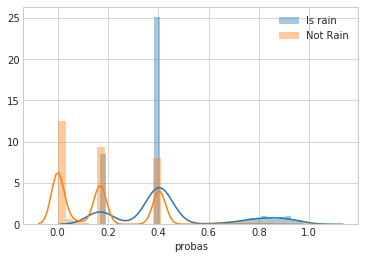

In [193]:
fig, ax = plt.subplots()
sns.distplot(df_results[df_results.is_rain==1]['probas'], ax=ax, label='Is rain')
sns.distplot(df_results[df_results.is_rain==0]['probas'], ax=ax, label='Not Rain')
# ax.set_ylim((0,5))
ax.legend()

In [103]:
def correct_grid(guess, actual):
    if guess == 0:
        if actual ==0:
            return 'true negative'
        else:
            return 'false negative'
    if guess == 1:
        if actual ==1:
            return 'true positive'
        else:
            return 'false positive'

In [188]:
list_of_blends = []
# blend = {'true negative':, 'true positive':, 'false negative':, 'falst positive':}
for threshold in [x/100 for x in range(1,50, 2)]:
    df_results['predicted_improved'] = df_results.probas.apply(lambda x: 1 if x >threshold else 0)
    
    _results = df_results.apply(lambda x: correct_grid(x['predicted_improved'], x['is_rain']), axis=1)
    _results_vals = _results.value_counts()
    try:
        false_pos = _results_vals.loc['false positive']
    except:
        false_pos = 0
    try:
        false_neg = _results_vals.loc['false negative']
    except:
        false_neg = 0
    list_of_blends.append({
        'threshold': threshold,
        'true negative':  _results_vals.loc['true negative'], 
        'true positive':  _results_vals.loc['true positive'],
        'false negative': false_neg, 
        'false positive': false_pos
    })

df_blends = pd.DataFrame(list_of_blends)

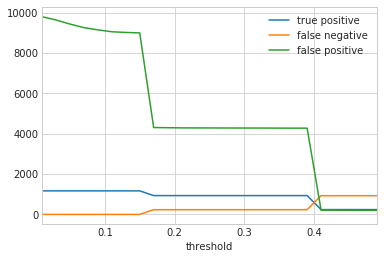

In [189]:
df_blends.set_index('threshold').loc[:, ['true positive', 'false negative', 'false positive']].plot()

In [190]:
df_blends['tp_fp'] = df_blends['true positive'] / (df_blends['false positive'] + df_blends['true positive'] )
df_blends['tp_f'] = df_blends['true positive'] / (df_blends['false positive'] + df_blends['false negative'] )

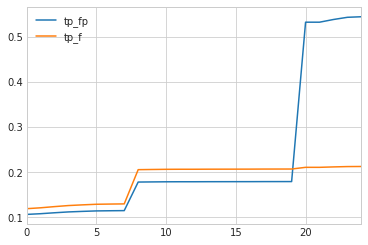

In [191]:
fig, ax = plt.subplots()
df_blends.tp_fp.plot(ax=ax)
df_blends.tp_f.plot(ax=ax)

ax.legend()

In [192]:
df_blends

,threshold,true negative,true positive,false negative,false positive,tp_fp,tp_f
0,0.01,6117,1168,0,9806,0.106433,0.119111
1,0.03,6277,1168,0,9646,0.108008,0.121086
2,0.05,6481,1168,0,9442,0.110085,0.123703
3,0.07,6658,1168,0,9265,0.111952,0.126066
4,0.09,6768,1168,0,9155,0.113145,0.127581
5,0.11,6862,1168,0,9061,0.114185,0.128904
6,0.13,6895,1168,0,9028,0.114555,0.129375
7,0.15,6920,1168,0,9003,0.114836,0.129735
8,0.17,11613,934,234,4310,0.178108,0.205546
9,0.19,11622,934,234,4301,0.178415,0.205954


How this seems now is that 39% proba should be 51% and a guess for rain. So, need to add .12 to everything to get proba effective

In [194]:
df_results.groupby(['is_rain']).mean()

,probas,predicted,predicted_improved
is_rain,,,
0,0.166250,0.012498,0.012623
1,0.443918,0.205479,0.205479
